## Установка библиотек

In [ ]:
!pip install plotly-express >> None

In [ ]:
!nvidia-smi

Wed Jul 10 07:00:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Импорт библиотек

In [96]:
# main_os
import os
import os.path
import random
import time
from warnings import filterwarnings
import glob
from pathlib import Path
from google.colab import drive

# math_lib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.io import loadmat
import nibabel as nib
from matplotlib import cm
from matplotlib.patches import Patch

# image_lib
import skimage
from IPython import display
from scipy.ndimage import gaussian_filter
from skimage import data, io, filters
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from PIL import Image
import cv2

# model_lib
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
from scipy.ndimage.filters import convolve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import BatchNormalization,MaxPooling2D,BatchNormalization
from keras.layers import Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN
from keras.layers import LSTM, GlobalAveragePooling2D, SeparableConv2D, ZeroPadding2D
from keras.layers import Convolution2D, ZeroPadding2D,Reshape, Conv2DTranspose
from keras.layers import LeakyReLU, GaussianNoise, GlobalMaxPooling2D, ReLU, Input, Concatenate
from keras import models
from keras.applications import VGG16,VGG19,inception_v3
from keras.utils import plot_model
import keras
from keras.models import Model
from keras import layers
from keras import backend as K
import cudf
from keras.optimizers import Adam, RMSprop, SGD, Adadelta

filterwarnings("ignore", category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning)
filterwarnings("ignore", category=UserWarning)

In [97]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Загрузка данных

In [167]:
Main_NII_Path = Path("/content/drive/MyDrive/CV/archive/imagesTr")
Label_NII_Path = Path("/content/drive/MyDrive/CV/archive/labelsTr")

In [168]:
NII_Images = list(Main_NII_Path.glob(r"*.nii"))
NII_Labels = list(Label_NII_Path.glob(r"*.nii"))
print("NII_Images: ", len(NII_Images))
print("NII_Labels: ", len(NII_Labels))

NII_Images:  20
NII_Labels:  20


In [169]:
Images_Series = pd.Series(NII_Images,name="IMAGE").astype(str)
Labels_Series = pd.Series(NII_Labels,name="LABEL").astype(str)

In [170]:
Main_Data = pd.concat([Images_Series,Labels_Series],axis=1)
print(Main_Data.head(10))

                                               IMAGE  \
0  /content/drive/MyDrive/CV/archive/imagesTr/la_...   
1  /content/drive/MyDrive/CV/archive/imagesTr/la_...   
2  /content/drive/MyDrive/CV/archive/imagesTr/la_...   
3  /content/drive/MyDrive/CV/archive/imagesTr/la_...   
4  /content/drive/MyDrive/CV/archive/imagesTr/la_...   
5  /content/drive/MyDrive/CV/archive/imagesTr/la_...   
6  /content/drive/MyDrive/CV/archive/imagesTr/la_...   
7  /content/drive/MyDrive/CV/archive/imagesTr/la_...   
8  /content/drive/MyDrive/CV/archive/imagesTr/la_...   
9  /content/drive/MyDrive/CV/archive/imagesTr/la_...   

                                               LABEL  
0  /content/drive/MyDrive/CV/archive/labelsTr/la_...  
1  /content/drive/MyDrive/CV/archive/labelsTr/la_...  
2  /content/drive/MyDrive/CV/archive/labelsTr/la_...  
3  /content/drive/MyDrive/CV/archive/labelsTr/la_...  
4  /content/drive/MyDrive/CV/archive/labelsTr/la_...  
5  /content/drive/MyDrive/CV/archive/labelsTr/la_... 

## Препроцессинг

In [171]:
Or_1_0 = []
Image_List = []
Label_List = []

for i_img,i_mask in zip(Main_Data["IMAGE"].values,Main_Data["LABEL"].values):

    Reading_Train_NII = nib.load(i_img)
    Reading_Label_NII = nib.load(i_mask)

    X_Images = Reading_Train_NII.get_fdata()
    X_Labels = Reading_Label_NII.get_fdata()

    Selecting_Image = X_Images[X_Images.shape[0]//2] / 255.
    Selecting_Label = X_Labels[X_Images.shape[0]//2] / 255.

    if np.mean(Selecting_Label) > 0:
        Or_1_0.append(1)
        Selecting_Image = Selecting_Image.astype("float32")
        Selecting_Label = Selecting_Label.astype("float32")

        Image_List.append(Selecting_Image)
        Label_List.append(Selecting_Label)
    else:
        Or_1_0.append(0)

In [172]:
for i_img,i_mask in zip(Main_Data["IMAGE"].values,Main_Data["LABEL"].values):
    Reading_Train_NII = nib.load(i_img)
    Reading_Label_NII = nib.load(i_mask)

    X_Images = Reading_Train_NII.get_fdata()
    X_Labels = Reading_Label_NII.get_fdata()

    Selecting_Image = X_Images[X_Images.shape[0]//2] / 255.
    Selecting_Label = X_Labels[X_Images.shape[0]//2] / 255.

    print(np.shape(Selecting_Image))
    print(np.shape(Selecting_Label))
    print("---"*20)

(320, 130)
(320, 130)
------------------------------------------------------------
(320, 110)
(320, 120)
------------------------------------------------------------
(320, 120)
(320, 120)
------------------------------------------------------------
(320, 130)
(320, 120)
------------------------------------------------------------
(320, 100)
(320, 120)
------------------------------------------------------------
(320, 120)
(320, 100)
------------------------------------------------------------
(320, 120)
(320, 110)
------------------------------------------------------------
(320, 120)
(320, 130)
------------------------------------------------------------
(320, 90)
(320, 110)
------------------------------------------------------------
(320, 120)
(320, 110)
------------------------------------------------------------
(320, 122)
(320, 122)
------------------------------------------------------------
(320, 100)
(320, 110)
------------------------------------------------------------
(320,

In [173]:
Main_Data["1_OR_0"] = Or_1_0

In [174]:
print(Image_List[0].shape)
print(Label_List[0].shape)

(320, 110)
(320, 120)


In [175]:
Testing_Trans = cv2.resize(Image_List[10],(256,256))
print(Testing_Trans.shape)

(256, 256)


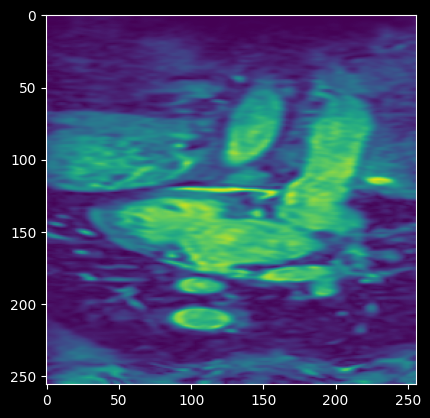

In [176]:
plt.imshow(Testing_Trans)

In [177]:
True_Seg = Main_Data[Main_Data["1_OR_0"] == 1]

In [178]:
Image_List = []
Label_List = []

for i_img,i_mask in zip(True_Seg["IMAGE"].values,True_Seg["LABEL"].values):

    Reading_Train_NII = nib.load(i_img)
    Reading_Label_NII = nib.load(i_mask)

    X_Images = Reading_Train_NII.get_fdata()
    X_Labels = Reading_Label_NII.get_fdata()

    Selecting_Image = X_Images[X_Images.shape[0]//2] / 255.
    Selecting_Label = X_Labels[X_Images.shape[0]//2] / 255.

    Selecting_Image = Selecting_Image.astype("float32")
    Selecting_Label = Selecting_Label.astype("float32")

    Resized_IMG = cv2.resize(Selecting_Image,(256,256))
    Resized_LABEL = cv2.resize(Selecting_Label,(256,256))

    Image_List.append(Resized_IMG)
    Label_List.append(Resized_LABEL)

In [179]:
for indexing_i in range(len(Image_List)):
    print("---"*10)
    print(Image_List[indexing_i].shape)
    print(Label_List[indexing_i].shape)

------------------------------
(256, 256)
(256, 256)
------------------------------
(256, 256)
(256, 256)
------------------------------
(256, 256)
(256, 256)
------------------------------
(256, 256)
(256, 256)
------------------------------
(256, 256)
(256, 256)
------------------------------
(256, 256)
(256, 256)
------------------------------
(256, 256)
(256, 256)
------------------------------
(256, 256)
(256, 256)
------------------------------
(256, 256)
(256, 256)
------------------------------
(256, 256)
(256, 256)
------------------------------
(256, 256)
(256, 256)
------------------------------
(256, 256)
(256, 256)
------------------------------
(256, 256)
(256, 256)
------------------------------
(256, 256)
(256, 256)
------------------------------
(256, 256)
(256, 256)
------------------------------
(256, 256)
(256, 256)
------------------------------
(256, 256)
(256, 256)
------------------------------
(256, 256)
(256, 256)


## Визуализация

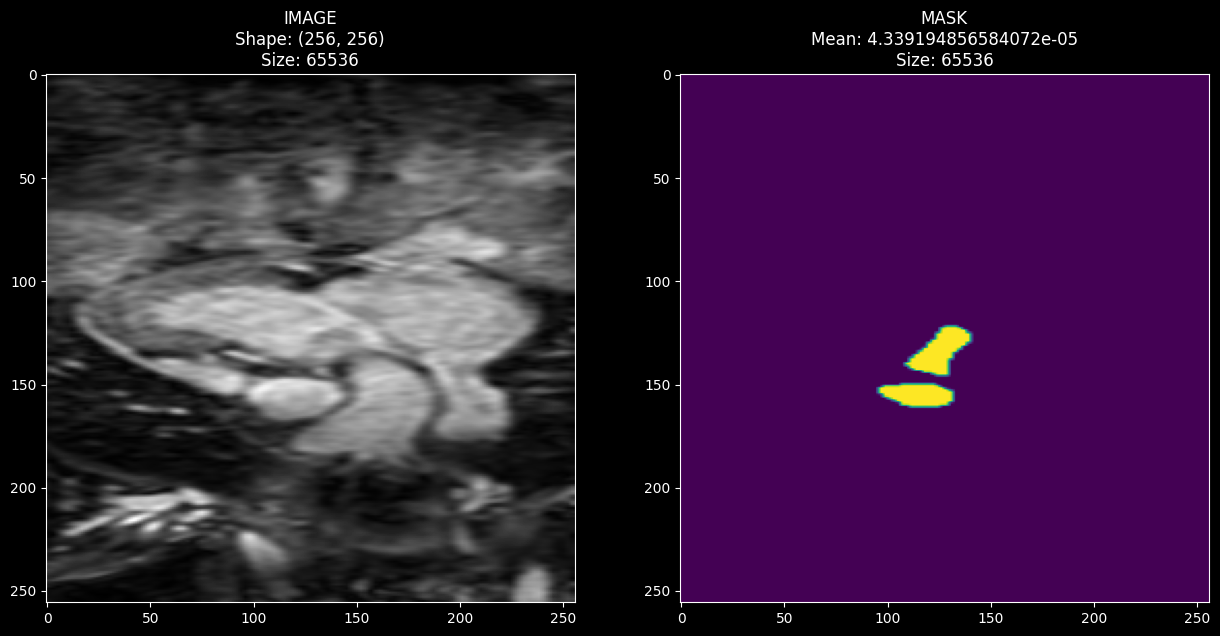

In [180]:
plt.style.use('dark_background')

figure, axis = plt.subplots(1, 2, figsize=(15, 16))
Picking_Example_IMG = Image_List[0]
Picking_Example_Label = Label_List[0]

axis[0].imshow(Picking_Example_IMG, cmap='gray')
axis[0].set_title(f"IMAGE\nShape: {Picking_Example_IMG.shape}\nSize: {Picking_Example_IMG.size}")
axis[1].imshow(Picking_Example_Label, cmap='viridis')
axis[1].set_title(f"MASK\nMean: {np.mean(Picking_Example_Label)}\nSize: {Picking_Example_Label.size}")

for ax in axis:
    ax.axis('on')
    ax.set_rasterized(True)

plt.show()

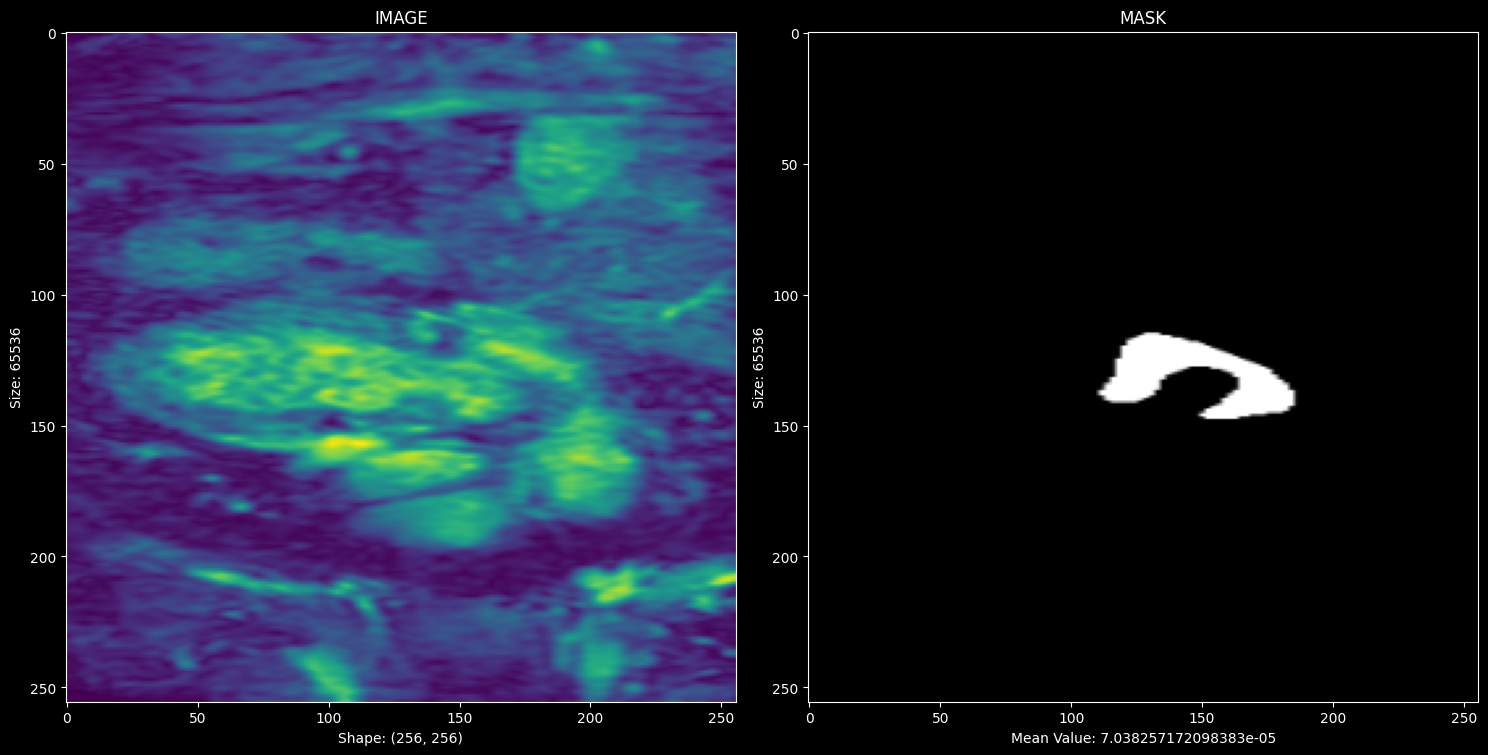

In [181]:
figure, axes = plt.subplots(1, 2, figsize=(15, 14))

Picking_Example_IMG = Image_List[2]
Picking_Example_Label = Label_List[2]

# Отображение изображения
axes[0].imshow(Picking_Example_IMG)
axes[0].set_xlabel(f'Shape: {Picking_Example_IMG.shape}')
axes[0].set_ylabel('Size: {}'.format(Picking_Example_IMG.size))
axes[0].set_title("IMAGE")
axes[0].axis('on')
axes[1].imshow(Picking_Example_Label, cmap='gray')
axes[1].set_xlabel(f'Mean Value: {np.mean(Picking_Example_Label)}')
axes[1].set_ylabel('Size: {}'.format(Picking_Example_Label.size))
axes[1].set_title("MASK")
axes[1].axis('on')

plt.tight_layout()
plt.show()

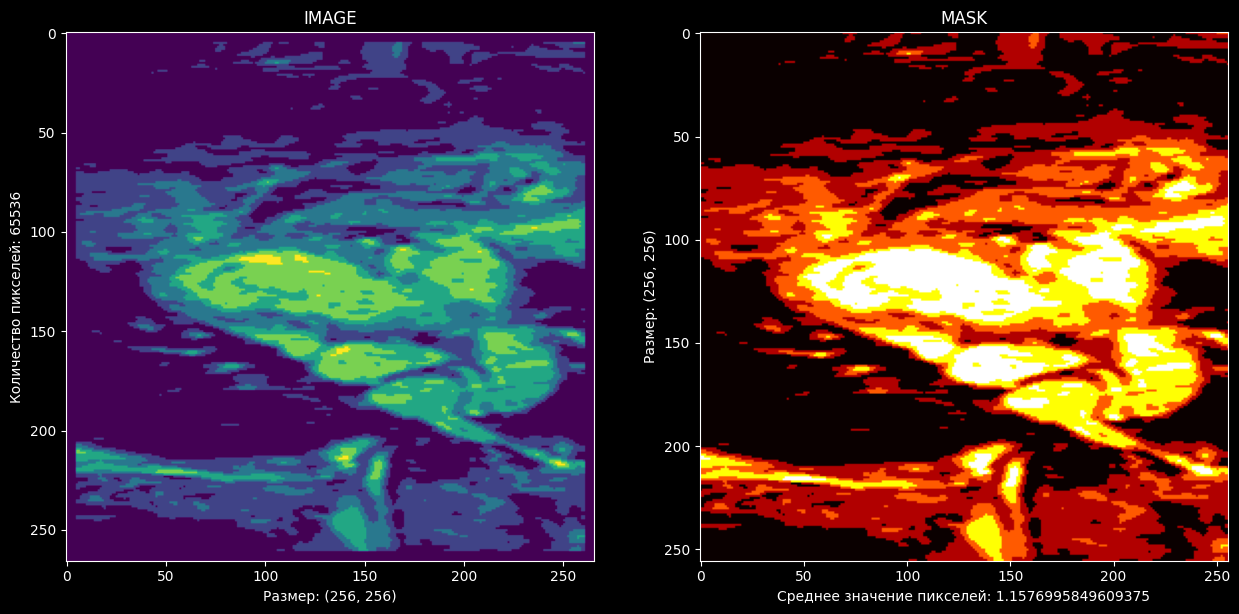

In [182]:
figure, axis = plt.subplots(1, 2, figsize=(15, 16))

Picking_Example_IMG = Image_List[12]
Picking_Example_Label = Label_List[8]
Picking_Example_IMG = Picking_Example_IMG.astype("uint8")
Picking_Example_Label = Picking_Example_Label.astype("uint8")
Canny_Image = cv2.Canny(Picking_Example_Label, 10, 100)
NP_Kernel = np.ones((5, 5), np.uint8)
Dilation_Image = cv2.dilate(Canny_Image, NP_Kernel, iterations=5)
Blend_Image = cv2.addWeighted(Picking_Example_IMG, 0.8, Dilation_Image, 0.4, 0.5)
normalized_image = cv2.normalize(Picking_Example_IMG, None, alpha=0, beta=255,
                                 norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

border_thickness = 5
Picking_Example_IMG_with_border = cv2.copyMakeBorder(normalized_image, border_thickness,
                                                     border_thickness, border_thickness,
                                                     border_thickness, cv2.BORDER_CONSTANT,
                                                     value=[0, 0, 0])

mask_cmap = cm.get_cmap('hot', max(Picking_Example_Label.max(), Blend_Image.max()) + 1)

axis[0].imshow(Picking_Example_IMG_with_border)
axis[0].set_xlabel(f"Размер: {Picking_Example_IMG.shape}")
axis[0].set_ylabel(f"Количество пикселей: {Picking_Example_IMG.size}")
axis[0].set_title("IMAGE")
axis[1].imshow(mask_cmap(Blend_Image))
axis[1].set_xlabel(f"Среднее значение пикселей: {np.mean(Blend_Image)}")
axis[1].set_ylabel(f"Размер: {Blend_Image.shape}")
axis[1].set_title("MASK")

plt.show()

Text(0.5, 1.0, 'MASK')

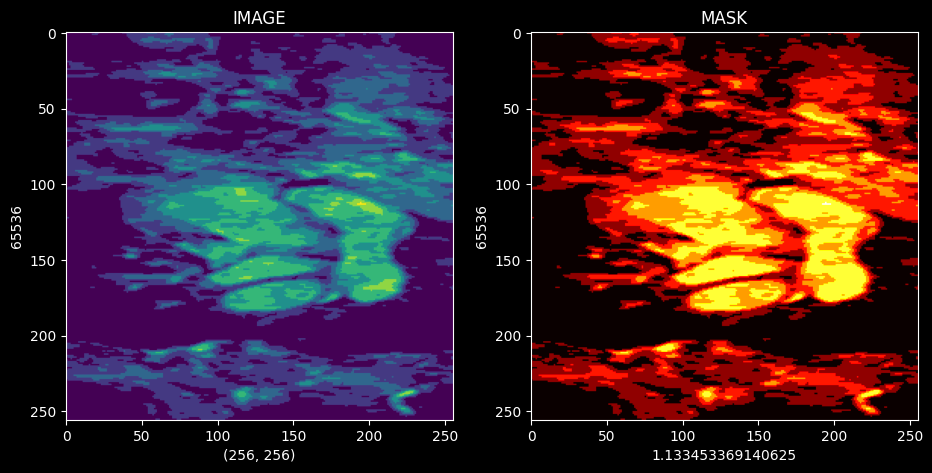

In [183]:
figure,axis = plt.subplots(1,2,figsize=(11,12))

Picking_Example_IMG = Image_List[13]
Picking_Example_Label = Label_List[13]
Picking_Example_Label = Picking_Example_Label.astype("uint8")
Picking_Example_IMG = Picking_Example_IMG.astype("uint8")

Canny_Image = cv2.Canny(Picking_Example_Label,10,100)

NP_Kernel = np.ones((5,5),np.uint8)
Dilation_Image = cv2.dilate(Canny_Image,NP_Kernel,iterations = 5)

Blend_Image = cv2.addWeighted(Picking_Example_IMG,0.8,Dilation_Image,0.4,0.5)

axis[0].imshow(Picking_Example_IMG)
axis[0].set_xlabel(Picking_Example_IMG.shape)
axis[0].set_ylabel(Picking_Example_IMG.size)
axis[0].set_title("IMAGE")

axis[1].imshow(Blend_Image,cmap="hot")
axis[1].set_xlabel(np.mean(Blend_Image))
axis[1].set_ylabel(Blend_Image.size)
axis[1].set_title("MASK")

Text(0.5, 1.0, 'MASK')

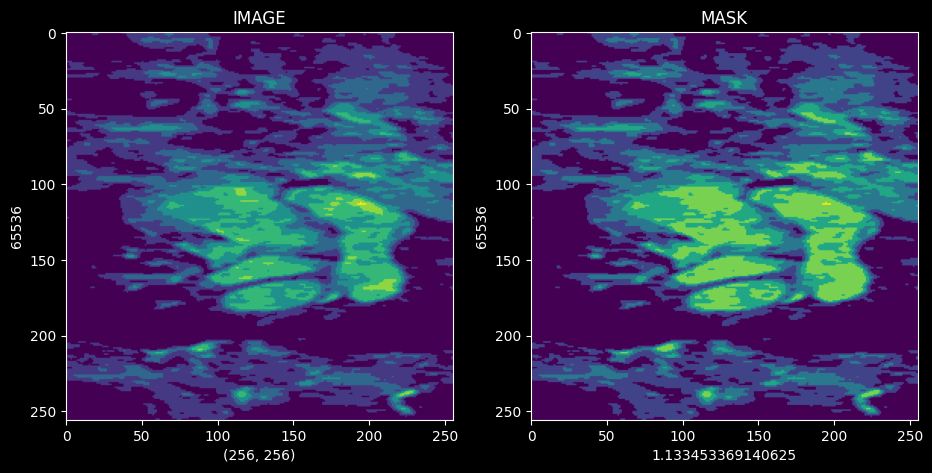

In [184]:
figure,axis = plt.subplots(1,2,figsize=(11,12))

Picking_Example_IMG = Image_List[13]
Picking_Example_Label = Label_List[13]
Picking_Example_Label = Picking_Example_Label.astype("uint8")
Picking_Example_IMG = Picking_Example_IMG.astype("uint8")

Blend_Image = cv2.addWeighted(Picking_Example_IMG,0.8,Picking_Example_Label,0.4,0.5)

axis[0].imshow(Picking_Example_IMG)
axis[0].set_xlabel(Picking_Example_IMG.shape)
axis[0].set_ylabel(Picking_Example_IMG.size)
axis[0].set_title("IMAGE")

axis[1].imshow(Blend_Image)
axis[1].set_xlabel(np.mean(Blend_Image))
axis[1].set_ylabel(Blend_Image.size)
axis[1].set_title("MASK")

Text(0.5, 1.0, 'MASK')

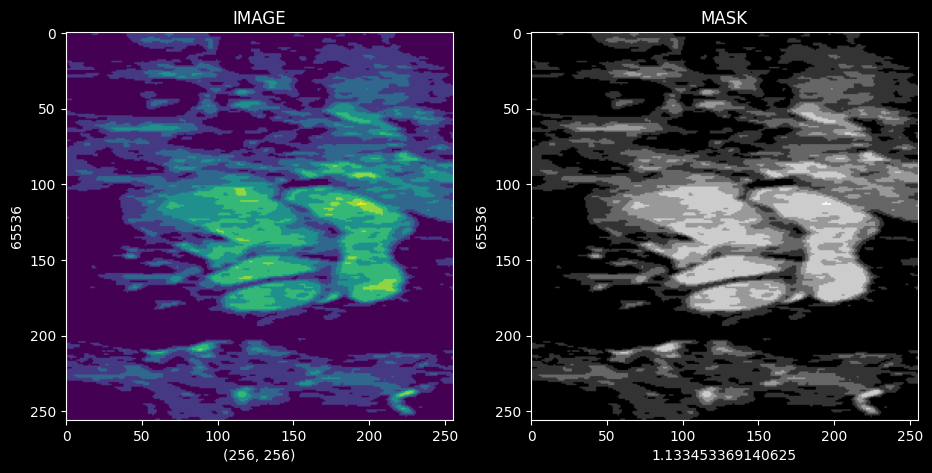

In [185]:
figure,axis = plt.subplots(1,2,figsize=(11,12))

Picking_Example_IMG = Image_List[13]
Picking_Example_Label = Label_List[13]
Picking_Example_Label = Picking_Example_Label.astype("uint8")
Picking_Example_IMG = Picking_Example_IMG.astype("uint8")

Blend_Image = cv2.addWeighted(Picking_Example_IMG,0.8,Picking_Example_Label,0.4,0.5)

axis[0].imshow(Picking_Example_IMG)
axis[0].set_xlabel(Picking_Example_IMG.shape)
axis[0].set_ylabel(Picking_Example_IMG.size)
axis[0].set_title("IMAGE")

axis[1].imshow(Blend_Image,cmap="gray")
axis[1].set_xlabel(np.mean(Blend_Image))
axis[1].set_ylabel(Blend_Image.size)
axis[1].set_title("MASK")

In [186]:
X_TRAIN = np.array(Image_List,dtype="float32")
print(X_TRAIN.shape)
X_LABEL = np.array(Label_List,dtype="float32")
print(X_LABEL.shape)

(18, 256, 256)
(18, 256, 256)


In [187]:
X_TRAIN = X_TRAIN.reshape(X_TRAIN.shape[0],X_TRAIN.shape[1],X_TRAIN.shape[2],1)
print(X_TRAIN.shape)
X_LABEL = X_LABEL.reshape(X_LABEL.shape[0],X_LABEL.shape[1],X_LABEL.shape[2],1)
print(X_LABEL.shape)

(18, 256, 256, 1)
(18, 256, 256, 1)


In [188]:
print(X_TRAIN[0:-1].shape)

(17, 256, 256, 1)


## Модель_1 (Root Mean Square Propagation, binary_crossentropy)

In [189]:
from tensorflow.keras.regularizers import l1_l2

In [190]:
Encoder1 = Sequential()
Encoder1.add(Conv2D(32,(5,5),kernel_initializer = 'he_normal',use_bias=True,name="ENCODER_INPUT"))
Encoder1.add(BatchNormalization())
Encoder1.add(ReLU())
Encoder1.add(Conv2D(64,(5,5),kernel_initializer = 'he_normal',use_bias=True))
Encoder1.add(BatchNormalization())
Encoder1.add(ReLU())
Encoder1.add(Conv2D(128,(2,2),kernel_initializer = 'he_normal',use_bias=True))
Encoder1.add(BatchNormalization())
Encoder1.add(ReLU())
Encoder1.add(Conv2D(128,(3,3),kernel_initializer = 'he_normal',use_bias=True))
Encoder1.add(BatchNormalization())
Encoder1.add(ReLU())

Decoder1 = Sequential()
Decoder1.add(Conv2DTranspose(128,(3,3)))
Decoder1.add(ReLU())
Decoder1.add(Conv2DTranspose(64,(2,2)))
Decoder1.add(ReLU())
Decoder1.add(Conv2DTranspose(32,(5,5)))
Decoder1.add(ReLU())
Decoder1.add(Conv2DTranspose(1,(5,5),name="DECODER_OUTPUT"))

In [191]:
AE_Structure1 = Sequential([Encoder1,Decoder1])

In [192]:
AE_Structure1.compile(loss="binary_crossentropy",
                     optimizer=RMSprop(),
                     metrics=["accuracy"])

In [193]:
AE_Model_1 = AE_Structure1.fit(X_TRAIN[0:-1],
                            X_LABEL[0:-1],epochs=100)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.0049 - accuracy: 0.9688
Epoch 2/100
1/1 [==============================] - 1s 707ms/step - loss: 0.0017 - accuracy: 0.9689
Epoch 3/100
1/1 [==============================] - 1s 726ms/step - loss: 0.0017 - accuracy: 0.9689
Epoch 4/100
1/1 [==============================] - 1s 725ms/step - loss: 0.0017 - accuracy: 0.9689
Epoch 5/100
1/1 [==============================] - 1s 721ms/step - loss: 0.0017 - accuracy: 0.9689
Epoch 6/100
1/1 [==============================] - 1s 727ms/step - loss: 0.0017 - accuracy: 0.9689
Epoch 7/100
1/1 [==============================] - 1s 726ms/step - loss: 0.0017 - accuracy: 0.9689
Epoch 8/100
1/1 [==============================] - 1s 728ms/step - loss: 0.0017 - accuracy: 0.9689
Epoch 9/100
1/1 [==============================] - 1s 727ms/step - loss: 0.0017 - accuracy: 0.9689
Epoch 10/100
1/1 [==============================] - 1s 734ms/step - loss: 0.0017 - accuracy: 0.9689
Epoch 11/100

loss: 0.0017 - accuracy: 0.9689





## Модель_2 (Adaptive Moment Estimation, binary_crossentropy)

In [194]:
Encoder2 = Sequential()
Encoder2.add(Conv2D(32,(5,5),kernel_initializer = 'he_normal',use_bias=True,name="ENCODER_INPUT"))
Encoder2.add(BatchNormalization())
Encoder2.add(ReLU())
Encoder2.add(Conv2D(64,(5,5),kernel_initializer = 'he_normal',use_bias=True))
Encoder2.add(BatchNormalization())
Encoder2.add(ReLU())
Encoder2.add(Conv2D(128,(2,2),kernel_initializer = 'he_normal',use_bias=True))
Encoder2.add(BatchNormalization())
Encoder2.add(ReLU())
Encoder2.add(Conv2D(128,(3,3),kernel_initializer = 'he_normal',use_bias=True))
Encoder2.add(BatchNormalization())
Encoder2.add(ReLU())

Decoder2 = Sequential()
Decoder2.add(Conv2DTranspose(128,(3,3)))
Decoder2.add(ReLU())
Decoder2.add(Conv2DTranspose(64,(2,2)))
Decoder2.add(ReLU())
Decoder2.add(Conv2DTranspose(32,(5,5)))
Decoder2.add(ReLU())
Decoder2.add(Conv2DTranspose(1,(5,5),name="DECODER_OUTPUT"))

In [195]:
AE_Structure2 = Sequential([Encoder2,Decoder2])

In [196]:
AE_Structure2.compile(loss="binary_crossentropy",
                     optimizer=Adam(learning_rate=0.0001),
                     metrics=["accuracy"])

In [197]:
AE_Model_2 = AE_Structure2.fit(X_TRAIN[0:-1],
                            X_LABEL[0:-1],epochs=100)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.0547 - accuracy: 0.9623
Epoch 2/100
1/1 [==============================] - 1s 743ms/step - loss: 0.0065 - accuracy: 0.9687
Epoch 3/100
1/1 [==============================] - 1s 764ms/step - loss: 0.0026 - accuracy: 0.9689
Epoch 4/100
1/1 [==============================] - 1s 755ms/step - loss: 0.0021 - accuracy: 0.9689
Epoch 5/100
1/1 [==============================] - 1s 738ms/step - loss: 0.0020 - accuracy: 0.9689
Epoch 6/100
1/1 [==============================] - 1s 747ms/step - loss: 0.0019 - accuracy: 0.9689
Epoch 7/100
1/1 [==============================] - 1s 751ms/step - loss: 0.0019 - accuracy: 0.9689
Epoch 8/100
1/1 [==============================] - 1s 745ms/step - loss: 0.0019 - accuracy: 0.9689
Epoch 9/100
1/1 [==============================] - 1s 747ms/step - loss: 0.0018 - accuracy: 0.9689
Epoch 10/100
1/1 [==============================] - 1s 745ms/step - loss: 0.0018 - accuracy: 0.9689
Epoch 11/100

loss: 0.0017 - accuracy: 0.9689

# Модель_3 (Adam, BinaryCrossentropy)

In [198]:
from keras.layers import UpSampling2D

In [199]:
from tensorflow.keras.losses import BinaryCrossentropy

In [200]:
# Encoder
Encoder3 = Sequential()
Encoder3.add(Conv2D(32, (5, 5), padding='same', kernel_initializer='he_normal', use_bias=True, input_shape=(256, 256, 1)))
Encoder3.add(BatchNormalization())
Encoder3.add(ReLU())
Encoder3.add(MaxPooling2D(pool_size=(2, 2)))  # Output: (128, 128, 32)

Encoder3.add(Conv2D(64, (5, 5), padding='same', kernel_initializer='he_normal', use_bias=True))
Encoder3.add(BatchNormalization())
Encoder3.add(ReLU())
Encoder3.add(MaxPooling2D(pool_size=(2, 2)))  # Output: (64, 64, 64)

Encoder3.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', use_bias=True))
Encoder3.add(BatchNormalization())
Encoder3.add(ReLU())
Encoder3.add(MaxPooling2D(pool_size=(2, 2)))  # Output: (32, 32, 128)

Encoder3.add(Dropout(0.5))  # Regularization

# Decoder
Decoder3 = Sequential()
Decoder3.add(Conv2DTranspose(128, (3, 3), padding='same', input_shape=(32, 32, 128)))
Decoder3.add(ReLU())
Decoder3.add(UpSampling2D(size=(2, 2)))  # Output: (64, 64, 128)

Decoder3.add(Conv2DTranspose(64, (3, 3), padding='same'))
Decoder3.add(ReLU())
Decoder3.add(UpSampling2D(size=(2, 2)))  # Output: (128, 128, 64)

Decoder3.add(Conv2DTranspose(32, (5, 5), padding='same'))
Decoder3.add(ReLU())
Decoder3.add(UpSampling2D(size=(2, 2)))  # Output: (256, 256, 32)

Decoder3.add(Conv2DTranspose(1, (3, 3), padding='same', name="DECODER_OUTPUT"))
Decoder3.add(ReLU())

In [201]:
# Сборка модели
autoencoder = Sequential([Encoder3, Decoder3])
autoencoder.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=["accuracy"])

In [202]:
autoencoder = autoencoder.fit(X_TRAIN[0:-1],
                            X_LABEL[0:-1],epochs=100)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 11.4451 - accuracy: 0.0740
Epoch 2/100
1/1 [==============================] - 0s 176ms/step - loss: 0.0018 - accuracy: 0.9689
Epoch 3/100
1/1 [==============================] - 0s 153ms/step - loss: 0.0017 - accuracy: 0.9689
Epoch 4/100
1/1 [==============================] - 0s 137ms/step - loss: 0.0017 - accuracy: 0.9689
Epoch 5/100
1/1 [==============================] - 0s 138ms/step - loss: 0.0017 - accuracy: 0.9689
Epoch 6/100
1/1 [==============================] - 0s 137ms/step - loss: 0.0017 - accuracy: 0.9689
Epoch 7/100
1/1 [==============================] - 0s 139ms/step - loss: 0.0017 - accuracy: 0.9689
Epoch 8/100
1/1 [==============================] - 0s 139ms/step - loss: 0.0017 - accuracy: 0.9689
Epoch 9/100
1/1 [==============================] - 0s 136ms/step - loss: 0.0017 - accuracy: 0.9689
Epoch 10/100
1/1 [==============================] - 0s 138ms/step - loss: 0.0017 - accuracy: 0.9689
Epoch 11/10

loss: 0.0017 - accuracy: 0.9689

# Модель_4 (Dice Loss)

In [203]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / denominator

In [204]:
AE_Structure4 = Sequential([Encoder2,Decoder2])

In [205]:
AE_Structure4.compile(loss=dice_loss,
                     optimizer=Adam(learning_rate=0.0001),
                     metrics=["accuracy"])

In [206]:
AE_Model_4 = AE_Structure4.fit(X_TRAIN[0:-1],
                            X_LABEL[0:-1],epochs=100)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.9996 - accuracy: 0.9689
Epoch 2/100
1/1 [==============================] - 1s 762ms/step - loss: 0.9996 - accuracy: 0.9689
Epoch 3/100
1/1 [==============================] - 1s 784ms/step - loss: 0.9996 - accuracy: 0.9689
Epoch 4/100
1/1 [==============================] - 1s 790ms/step - loss: 0.9995 - accuracy: 0.9689
Epoch 5/100
1/1 [==============================] - 1s 791ms/step - loss: 0.9995 - accuracy: 0.9689
Epoch 6/100
1/1 [==============================] - 1s 782ms/step - loss: 0.9995 - accuracy: 0.9689
Epoch 7/100
1/1 [==============================] - 1s 779ms/step - loss: 0.9994 - accuracy: 0.9689
Epoch 8/100
1/1 [==============================] - 1s 786ms/step - loss: 0.9994 - accuracy: 0.9689
Epoch 9/100
1/1 [==============================] - 1s 792ms/step - loss: 0.9994 - accuracy: 0.9689
Epoch 10/100
1/1 [==============================] - 1s 786ms/step - loss: 0.9993 - accuracy: 0.9689
Epoch 11/100

loss: 0.9993 - accuracy: 0.4689

# Модель_5 (Intersection over Union)

In [207]:
def iou_loss(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    total = tf.reduce_sum(y_true + y_pred)
    union = total - intersection
    IoU = intersection / union
    return 1 - IoU

In [208]:
AE_Structure5 = Sequential([Encoder2,Decoder2])

In [209]:
AE_Structure5.compile(loss=iou_loss,
                     optimizer=Adam(learning_rate=0.0001),
                     metrics=["accuracy"])

In [210]:
AE_Model_5 = AE_Structure5.fit(X_TRAIN[0:-1],
                            X_LABEL[0:-1],epochs=100)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.9996 - accuracy: 0.4727
Epoch 2/100
1/1 [==============================] - 1s 749ms/step - loss: 0.9996 - accuracy: 0.4904
Epoch 3/100
1/1 [==============================] - 1s 785ms/step - loss: 0.9996 - accuracy: 0.5089
Epoch 4/100
1/1 [==============================] - 1s 779ms/step - loss: 0.9996 - accuracy: 0.5280
Epoch 5/100
1/1 [==============================] - 1s 761ms/step - loss: 0.9996 - accuracy: 0.5471
Epoch 6/100
1/1 [==============================] - 1s 766ms/step - loss: 0.9996 - accuracy: 0.5665
Epoch 7/100
1/1 [==============================] - 1s 772ms/step - loss: 0.9996 - accuracy: 0.5867
Epoch 8/100
1/1 [==============================] - 1s 771ms/step - loss: 0.9996 - accuracy: 0.6073
Epoch 9/100
1/1 [==============================] - 1s 771ms/step - loss: 0.9996 - accuracy: 0.6273
Epoch 10/100
1/1 [==============================] - 1s 768ms/step - loss: 0.9996 - accuracy: 0.6463
Epoch 11/100

loss: 0.9998 - accuracy: 0.9689

# Модель_6 (Combo Loss)

In [211]:
from tensorflow.keras.metrics import MeanIoU

In [212]:
def combo_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

In [213]:
AE_Structure6 = Sequential([Encoder2,Decoder2])

In [214]:
AE_Structure6.compile(loss=combo_loss,
                     optimizer=Adam(learning_rate=0.001),
                     metrics=["accuracy"])

In [215]:
AE_Model_6 = AE_Structure6.fit(X_TRAIN[0:-1],
                            X_LABEL[0:-1],epochs=100)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 1.0010 - accuracy: 0.9689
Epoch 2/100
1/1 [==============================] - 1s 753ms/step - loss: 1.0009 - accuracy: 0.9689
Epoch 3/100
1/1 [==============================] - 1s 775ms/step - loss: 1.0067 - accuracy: 0.9689
Epoch 4/100
1/1 [==============================] - 1s 765ms/step - loss: 1.0008 - accuracy: 0.9689
Epoch 5/100
1/1 [==============================] - 1s 762ms/step - loss: 1.0009 - accuracy: 0.9689
Epoch 6/100
1/1 [==============================] - 1s 765ms/step - loss: 1.0009 - accuracy: 0.9689
Epoch 7/100
1/1 [==============================] - 1s 768ms/step - loss: 1.0009 - accuracy: 0.9689
Epoch 8/100
1/1 [==============================] - 1s 760ms/step - loss: 1.0009 - accuracy: 0.9689
Epoch 9/100
1/1 [==============================] - 1s 765ms/step - loss: 1.0009 - accuracy: 0.9689
Epoch 10/100
1/1 [==============================] - 1s 769ms/step - loss: 1.0009 - accuracy: 0.9689
Epoch 11/100

loss: 1.0004 - accuracy: 0.9689

# Модель_7 (Combo Loss, En1, Dec1)

In [216]:
AE_Structure7 = Sequential([Encoder1,Decoder1])

In [217]:
AE_Structure7.compile(loss=combo_loss,
                     optimizer=Adam(learning_rate=0.0001),
                     metrics=["accuracy"])

In [218]:
AE_Model_7 = AE_Structure7.fit(X_TRAIN[0:-1],
                            X_LABEL[0:-1],epochs=100)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 1.0014 - accuracy: 0.9689
Epoch 2/100
1/1 [==============================] - 1s 754ms/step - loss: 1.0014 - accuracy: 0.9689
Epoch 3/100
1/1 [==============================] - 1s 789ms/step - loss: 1.0014 - accuracy: 0.9689
Epoch 4/100
1/1 [==============================] - 1s 774ms/step - loss: 1.0013 - accuracy: 0.9689
Epoch 5/100
1/1 [==============================] - 1s 773ms/step - loss: 1.0013 - accuracy: 0.9689
Epoch 6/100
1/1 [==============================] - 1s 773ms/step - loss: 1.0013 - accuracy: 0.9689
Epoch 7/100
1/1 [==============================] - 1s 777ms/step - loss: 1.0013 - accuracy: 0.9689
Epoch 8/100
1/1 [==============================] - 1s 777ms/step - loss: 1.0013 - accuracy: 0.9689
Epoch 9/100
1/1 [==============================] - 1s 779ms/step - loss: 1.0012 - accuracy: 0.9689
Epoch 10/100
1/1 [==============================] - 1s 777ms/step - loss: 1.0012 - accuracy: 0.9689
Epoch 11/100

loss: 0.9974 - accuracy: 0.9689

# Модель_8 (Добавление Dropout)

In [219]:
from tensorflow.keras.layers import Dropout

In [220]:
# Encoder
Encoder3 = Sequential()
Encoder3.add(Conv2D(32, (5, 5), kernel_initializer='he_normal', use_bias=True, name="ENCODER_INPUT"))
Encoder3.add(BatchNormalization())
Encoder3.add(ReLU())
Encoder3.add(Dropout(0.3))  # Dropout layer

Encoder3.add(Conv2D(64, (5, 5), kernel_initializer='he_normal', use_bias=True))
Encoder3.add(BatchNormalization())
Encoder3.add(ReLU())
Encoder3.add(Dropout(0.3))  # Dropout layer

Encoder3.add(Conv2D(128, (2, 2), kernel_initializer='he_normal', use_bias=True))
Encoder3.add(BatchNormalization())
Encoder3.add(ReLU())
Encoder3.add(Dropout(0.3))  # Dropout layer

Encoder3.add(Conv2D(128, (3, 3), kernel_initializer='he_normal', use_bias=True))
Encoder3.add(BatchNormalization())
Encoder3.add(ReLU())
Encoder3.add(Dropout(0.3))  # Dropout layer

# Decoder
Decoder3 = Sequential()
Decoder3.add(Conv2DTranspose(128, (3, 3)))
Decoder3.add(ReLU())
Decoder3.add(Dropout(0.3))  # Dropout layer

Decoder3.add(Conv2DTranspose(64, (2, 2)))
Decoder3.add(ReLU())
Decoder3.add(Dropout(0.3))  # Dropout layer

Decoder3.add(Conv2DTranspose(32, (5, 5)))
Decoder3.add(ReLU())
Decoder3.add(Dropout(0.3))  # Dropout layer

Decoder3.add(Conv2DTranspose(1, (5, 5), name="DECODER_OUTPUT"))

In [221]:
AE_Structure8 = Sequential([Encoder3,Decoder3])

In [222]:
AE_Structure8.compile(loss="binary_crossentropy",
                     optimizer=RMSprop(),
                     metrics=["accuracy"])

In [223]:
AE_Model_8 = AE_Structure8.fit(X_TRAIN[0:-1],
                            X_LABEL[0:-1],epochs=100)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 2.8340 - accuracy: 0.6350
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 0.0019 - accuracy: 0.9689
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 0.0019 - accuracy: 0.9689
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 0.0019 - accuracy: 0.9689
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 0.0019 - accuracy: 0.9689
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 0.0019 - accuracy: 0.9689
Epoch 7/100
1/1 [==============================] - 1s 1s/step - loss: 0.0019 - accuracy: 0.9689
Epoch 8/100
1/1 [==============================] - 1s 1s/step - loss: 0.0019 - accuracy: 0.9689
Epoch 9/100
1/1 [==============================] - 1s 1s/step - loss: 0.0019 - accuracy: 0.9689
Epoch 10/100
1/1 [==============================] - 1s 1s/step - loss: 0.0019 - accuracy: 0.9689
Epoch 11/100
1/1 [=====================

Добавление Dropout слоев не улучшило метрику.
loss: 0.0017 - accuracy: 0.9689

# Модель_9 (Adam, Dropout)

In [224]:
AE_Structure9 = Sequential([Encoder3,Decoder3])

In [225]:
AE_Structure9.compile(loss="binary_crossentropy",
                     optimizer=Adam(learning_rate=0.01),
                     metrics=["accuracy"])

In [226]:
AE_Model_9 = AE_Structure9.fit(X_TRAIN[0:-1],
                            X_LABEL[0:-1],epochs=100)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.0017 - accuracy: 0.9689
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 0.0017 - accuracy: 0.9689
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 0.0017 - accuracy: 0.9689
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 0.0017 - accuracy: 0.9689
Epoch 5/100
1/1 [==============================] - 1s 1000ms/step - loss: 0.0017 - accuracy: 0.9689
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 0.0017 - accuracy: 0.9689
Epoch 7/100
1/1 [==============================] - 1s 1s/step - loss: 0.0017 - accuracy: 0.9689
Epoch 8/100
1/1 [==============================] - 1s 1s/step - loss: 0.0017 - accuracy: 0.9689
Epoch 9/100
1/1 [==============================] - 1s 1s/step - loss: 0.0017 - accuracy: 0.9689
Epoch 10/100
1/1 [==============================] - 1s 1s/step - loss: 0.0017 - accuracy: 0.9689
Epoch 11/100
1/1 [=================

loss: 0.0017 - accuracy: 0.9689

# Визуализация предсказаний

In [237]:
Prediction_MASK = AE_Structure8.predict(X_TRAIN[:10])

1/1 [==============================] - 1s 508ms/step


Text(0.5, 1.0, 'PREDICTION')

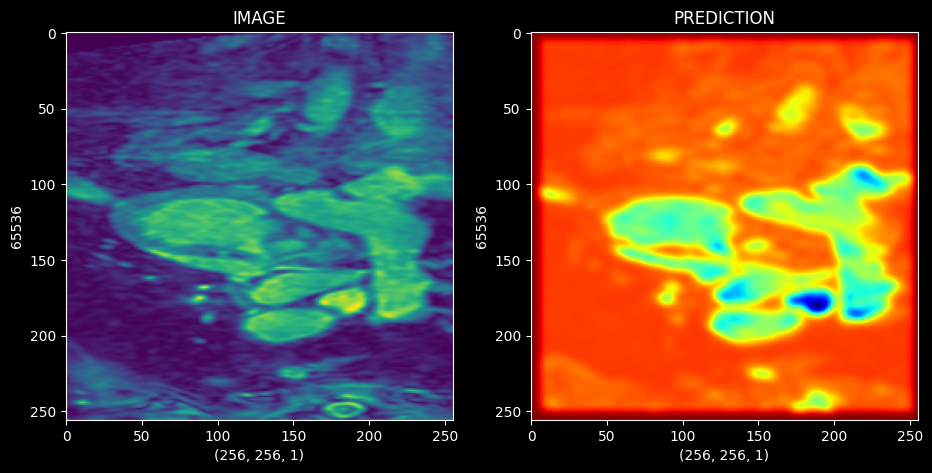

In [238]:
figure,axis = plt.subplots(1,2,figsize=(11,12))
img_number = 1

Original_Img = X_TRAIN[img_number]
Predict_Mask = Prediction_MASK[img_number]

axis[0].imshow(Original_Img)
axis[0].set_xlabel(Original_Img.shape)
axis[0].set_ylabel(Original_Img.size)
axis[0].set_title("IMAGE")
axis[1].imshow(Predict_Mask,cmap="jet")
axis[1].set_xlabel(Predict_Mask.shape)
axis[1].set_ylabel(Predict_Mask.size)
axis[1].set_title("PREDICTION")

Text(0.5, 1.0, 'PREDICTION')

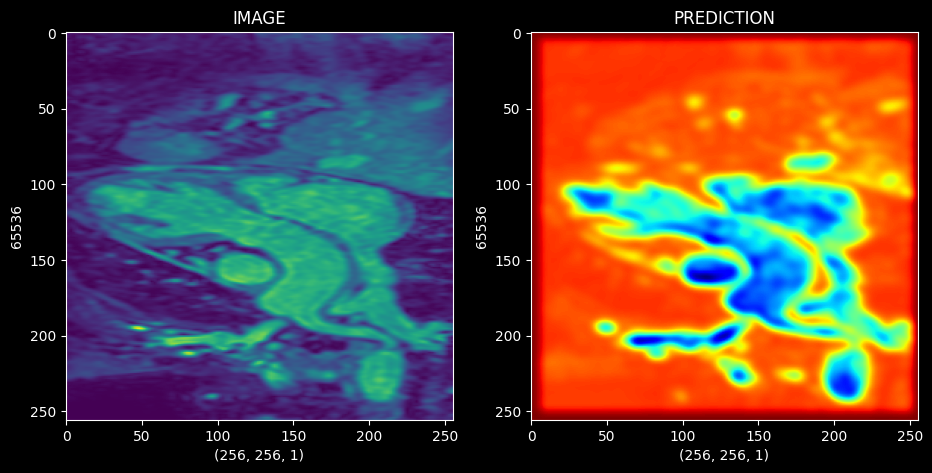

In [239]:
figure,axis = plt.subplots(1,2,figsize=(11,12))
img_number = 3

Original_Img = X_TRAIN[img_number]
Predict_Mask = Prediction_MASK[img_number]

axis[0].imshow(Original_Img)
axis[0].set_xlabel(Original_Img.shape)
axis[0].set_ylabel(Original_Img.size)
axis[0].set_title("IMAGE")
axis[1].imshow(Predict_Mask,cmap="jet")
axis[1].set_xlabel(Predict_Mask.shape)
axis[1].set_ylabel(Predict_Mask.size)
axis[1].set_title("PREDICTION")

Text(0.5, 1.0, 'PREDICTION')

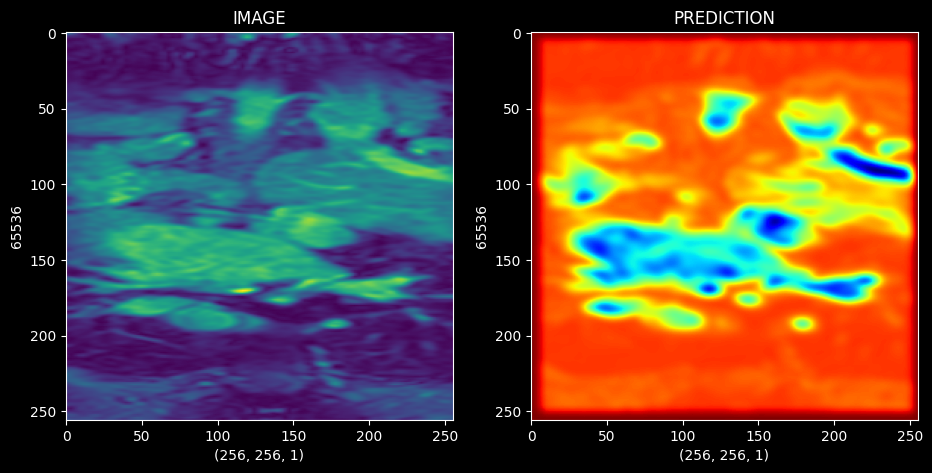

In [240]:
figure,axis = plt.subplots(1,2,figsize=(11,12))
img_number = 9

Original_Img = X_TRAIN[img_number]
Predict_Mask = Prediction_MASK[img_number]

axis[0].imshow(Original_Img)
axis[0].set_xlabel(Original_Img.shape)
axis[0].set_ylabel(Original_Img.size)
axis[0].set_title("IMAGE")
axis[1].imshow(Predict_Mask,cmap="jet")
axis[1].set_xlabel(Predict_Mask.shape)
axis[1].set_ylabel(Predict_Mask.size)
axis[1].set_title("PREDICTION")

# Вывод:

Модель_1: архитектура 1 функция потерь – бинарная кросс энтропия, оптимизатор - Root Mean Square Propagation. Метрики: loss: 0.0017 - accuracy: 0.9689

Модель_2: архитектура 2, функция потерь – бинарная кросс энтропия, оптимизатор - Adaptive Moment Estimation. Метрики: loss: 0.0017 - accuracy: 0.9689

Модель_3: архитектура 3, функция потерь – бинарная кросс энтропия, оптимизатор - Adaptive Moment Estimation. Метрики: loss: 0.0017 - accuracy: 0.9689

Модель_4: архитектура 2, функция потерь – Dice Loss, оптимизатор - Adaptive Moment Estimation. Метрики: loss: 0.9993 - accuracy: 0.4689

Модель_5: архитектура 2, функция потерь – Intersection over Union, оптимизатор - Adaptive Moment Estimation. Метрики: loss: 0.9997 - accuracy: 0.9689

Модель_6: архитектура 2, функция потерь – Combo Loss, оптимизатор - Adaptive Moment Estimation. Метрики: loss: 1.0004 - accuracy: 0.9689

Модель_7: архитектура 1, функция потерь – Combo Loss, оптимизатор - Adaptive Moment Estimation. Метрики: loss: 0.9974 - accuracy: 0.9689

Модель_8: архитектура 4, функция потерь – бинарная кросс энтропия, оптимизатор - Root Mean Square Propagation. Метрики: loss: 0.0017 - accuracy: 0.9689

Модель_9: архитектура 4, функция потерь – бинарная кросс энтропия, оптимизатор - Adaptive Moment Estimation. Метрики: loss: 0.0017 - accuracy: 0.9689






Не удалось поднять метрику выше, чем на уроке.

Были использованы разные комбинации оптимизатора, функции потерь, скорости обучения и архитектуры модели. Практически во всех вариантах accuracy = 0.9689. Это высокий результат, но поднять его не удалось. Функция потерь Dice Loss показала себя плохо (accuracy: 0.4689).